## BUSINESS PROBLEM

In [1]:
#The UK-based retail company wants to determine a roadmap for its sales and marketing activities. 
#In order for the company to make medium-long term plans, it is necessary to estimate the potential 
#value that existing customers will provide to the company in the future.

In [2]:
pip install lifetimes

Note: you may need to restart the kernel to use updated packages.


### DATASET

In [35]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

In [4]:
# CLTV = Expected Number of Transaction * Expected Average Profit
# CLTV = (customer value / churn rate) * profit margin
# (Customer Value = Purcahse Frequency * Average Order Value)
# CLTV = BG/NBD Model * Gamma Gamma Submodel

#### BG/NBD MODEL(Beta Geometric/Negative Binomial Distribution)

In [5]:
# We will find expected number of transaction with BG/NBD Model
# BG/NBD(Beta Geometric/Negative Binomial Distribution)(BUY TILL YOU DIE)
# Modeling the distribution of the general population through probability and reduce it to the indivual

# BG/NBD Model models two processes for Expected Number of Transaction:
    # Transaction Process(Buy)  + Dropout Process(Till You Die)
    
    #Transaction Process: The number of transactions that can be performed by a customer in a certain period of 
    #time, as long as he is alive, is distributed with the transaction rate parameter. 
    ## That is, as long as a customer is alive, he will continue to make random purchases around his transaction rate
    # Transaction rates each. varies specific to the customer, gamma is distributed for the entire audience (r, a)
    #We can reduce the mass by inferring it from a population whose distribution you know.


# DROPUT PROCESS(TILL YOU DIE): each customer has a dropout rate with probability p
# Dropout rates vary for each customer and beta is distributed for the entire audience (a,b)

#### GAMMA GAMMA MODEL

In [6]:
# Used to estimate how much profit a customer can generate on average per transaction
# We will find expected average profit
# The monetary value of a customer's transactions is randomly distributed around the average of the transaction values.
# Average transaction value may vary between users over time, but does not vary for an individual user
# Expected transaction value is gamma distributed among all customers

## DATA PREPARATION

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' %x)

In [8]:
# Define outlier_thresholds and replace_with_thresholds functions required to suppress outliers.
# When calculating cltv values, freq values must be int. Therefore, round the upper and lower values with round().

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

    
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 0)

In [9]:
df_ = pd.read_excel("/Users/yasemincingoz/Desktop/CLTV_Prediction/online_retail_II.xlsx")
df= df_.copy()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,525461.0000,10.3377,107.4241,-9600.0000,1.0000,3.0000,10.0000,19152.0000
Price,525461.0000,4.6888,146.1269,-53594.3600,1.2500,2.1000,4.2100,25111.0900
Customer ID,417534.0000,15360.6455,1680.8113,12346.0000,13983.0000,15311.0000,16799.0000,18287.0000


In [10]:
# There are minus values in Qunatity and price. We have to fix these.

In [11]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom


In [12]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [13]:
df.dropna(inplace=True)
# Drop the null values. If we don't know the customer ID, we can't know  and predict who is the best customer or will be.

In [14]:
df.describe().T
# after we drop the null values, price turned out to be normal but there is still problem in Quantity.

,count,mean,std,min,25%,50%,75%,max
Quantity,417534.0000,12.7588,101.2204,-9360.0000,2.0000,4.0000,12.0000,19152.0000
Price,417534.0000,3.8875,71.1318,0.0000,1.2500,1.9500,3.7500,25111.0900
Customer ID,417534.0000,15360.6455,1680.8113,12346.0000,13983.0000,15311.0000,16799.0000,18287.0000


In [15]:
# Retrieve the columns that not starts with 'C' in Invoice. Columns starts with 'C' shows the returned products.
df = df[~df['Invoice'].str.contains('C', na=False)]
df.describe().T

# The problem in Quantity columns is fixed.

,count,mean,std,min,25%,50%,75%,max
Quantity,407695.0000,13.5867,96.8422,1.0000,2.0000,5.0000,12.0000,19152.0000
Price,407695.0000,3.2942,34.7567,0.0000,1.2500,1.9500,3.7500,10953.5000
Customer ID,407695.0000,15368.5041,1679.7957,12346.0000,13997.0000,15321.0000,16812.0000,18287.0000


In [16]:
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,407664.0000,13.5856,96.8407,1.0000,2.0000,5.0000,12.0000,19152.0000
Price,407664.0000,3.2944,34.7580,0.0010,1.2500,1.9500,3.7500,10953.5000
Customer ID,407664.0000,15368.5926,1679.7621,12346.0000,13997.0000,15321.0000,16812.0000,18287.0000


#### DATA ANALYSIS

In [17]:
# We will calculate threshold values for Quantity. 
# Then it will replace the values above those threshold values with the threshold value.

replace_with_thresholds(df, 'Quantity')
replace_with_thresholds(df, 'Price')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,407664.0000,11.9053,28.7106,1.0000,2.0000,5.0000,12.0000,358.0000
Price,407664.0000,3.0057,3.2517,0.0010,1.2500,1.9500,3.7500,37.0000
Customer ID,407664.0000,15368.5926,1679.7621,12346.0000,13997.0000,15321.0000,16812.0000,18287.0000


In [18]:
df['TotalPrice'] = df['Quantity'] * df['Price']
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom,83.4000
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom,81.0000
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom,81.0000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom,100.8000
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom,30.0000
...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.9500,17530.0000,United Kingdom,5.9000
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.7500,17530.0000,United Kingdom,3.7500
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.7500,17530.0000,United Kingdom,3.7500
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.7500,17530.0000,United Kingdom,7.5000


In [19]:
df["InvoiceDate"].max()

Timestamp('2010-12-09 20:01:00')

In [20]:
# the day we made the analysis
today_date = dt.datetime(2010, 12, 11)

### PREPARATION OF LIFTIME DATA STRUCTURE

In [21]:
#recency: time since last purchase
#T: age of the customer. Weekly (how long before the date of analysis was the first purchase made)
#Frequency: total number of recurring purchases (freq>1)
#monetary value: average earnings per purchase

In [22]:
cltv_df = df.groupby('Customer ID').agg({'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                                                        lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
                                        'Invoice': lambda num: num.nunique(),
                                        'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
cltv_df.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0000          196        361       11   372.8600
12347.0000           37         40        2  1323.3200
12348.0000            0         74        1   222.1600
12349.0000          181        225        3  2295.1400
12351.0000            0         11        1   300.9300

In [23]:
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,196,361,11,372.8600
12347.0000,37,40,2,1323.3200
12348.0000,0,74,1,222.1600
12349.0000,181,225,3,2295.1400
12351.0000,0,11,1,300.9300


In [24]:
# Monetary value: average earnings per purchase

cltv_df['monetary'] = cltv_df['monetary'] / cltv_df['frequency']
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4312.0000,133.9986,132.8272,0.0000,0.0000,105.0000,254.0000,373.0000
T,4312.0000,225.4970,118.9098,1.0000,117.0000,253.0000,329.0000,374.0000
frequency,4312.0000,4.4557,8.1702,1.0000,1.0000,2.0000,5.0000,205.0000
monetary,4312.0000,358.6374,347.6767,2.9500,178.4787,283.1710,418.8906,5633.4950


In [25]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2893.0000,199.7242,114.7534,0.0000,103.0000,209.0000,301.0000,373.0000
T,2893.0000,261.7515,103.3122,7.0000,196.0000,288.0000,360.0000,374.0000
frequency,2893.0000,6.1507,9.5274,2.0000,2.0000,4.0000,7.0000,205.0000
monetary,2893.0000,374.1784,340.0327,10.8222,199.7825,298.9629,436.9967,5633.4950


In [26]:
#Convert recency and T to the weekly value

cltv_df['recency'] = cltv_df['recency'] / 7
cltv_df['T'] = cltv_df['T'] / 7
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2893.0000,28.5320,16.3933,0.0000,14.7143,29.8571,43.0000,53.2857
T,2893.0000,37.3931,14.7589,1.0000,28.0000,41.1429,51.4286,53.4286
frequency,2893.0000,6.1507,9.5274,2.0000,2.0000,4.0000,7.0000,205.0000
monetary,2893.0000,374.1784,340.0327,10.8222,199.7825,298.9629,436.9967,5633.4950


## ESTABLISHMENT of BG-NBD MODEL

In [27]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
#This creates an instance of the BetaGeoFitter class. 
#The penalizer_coef parameter is used for regularization to prevent overfitting. 

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])
#It fits the BG/NBD model to the data. 

<lifetimes.BetaGeoFitter: fitted with 2893 subjects, a: 0.14, alpha: 10.85, b: 2.72, r: 2.13>

In [28]:
# Who are the 10 customers we expect to make the most purchases within 1 week?"

bgf.conditional_expected_number_of_purchases_up_to_time(1, 
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

# We can also use bgf.predict()
# we found the customer ID's and expected number of purchases

Customer ID
14911.0000   3.2155
17850.0000   2.4259
12748.0000   2.2820
15311.0000   1.9107
13089.0000   1.7232
14606.0000   1.6210
14156.0000   1.6040
13694.0000   1.4845
17841.0000   1.4478
18102.0000   1.4136
dtype: float64

In [29]:
cltv_df['expected_purc_1_week'] = bgf.predict(1, 
                                            cltv_df['frequency'],
                                            cltv_df['recency'],
                                            cltv_df['T'])
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12346.0000,28.0000,51.5714,11,33.8964,0.0315
12347.0000,5.2857,5.7143,2,661.6600,0.2383
12349.0000,25.8571,32.1429,3,765.0467,0.1116
12352.0000,2.2857,4.0000,2,171.9000,0.2604
12356.0000,6.2857,8.5714,3,1187.4167,0.2490


In [30]:
# Who are the 10 customers we expect to make the most purchases within 1 month?

bgf.predict(4, 
         cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T']).sort_values(ascending=False).head(10)


Customer ID
14911.0000   12.8204
17850.0000    9.6720
12748.0000    9.0980
15311.0000    7.6179
13089.0000    6.8705
14606.0000    6.4630
14156.0000    6.3953
13694.0000    5.9187
17841.0000    5.7725
18102.0000    5.6359
dtype: float64

In [31]:
bgf.predict(4, 
         cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T']).sum()

1792.9810117736224

In [32]:
# Who are the 10 customers we expect to make the most purchases within 12 months?"

cltv_df["expected_purch_12_month"] = bgf.predict(4 * 12, 
         cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

In [33]:
bgf.predict(4 * 12, 
         cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
14911.0000   147.9802
17850.0000   111.6068
12748.0000   104.9911
15311.0000    87.9278
13089.0000    79.2956
14606.0000    74.5868
14156.0000    73.8157
13694.0000    68.3001
17841.0000    66.6220
18102.0000    65.0494
dtype: float64

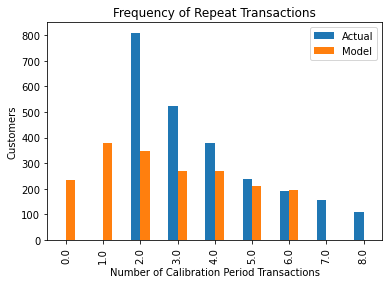

In [36]:
# Evaluation of predicted results

import matplotlib.pyplot as plt
plot_period_transactions(bgf)
plt.show()

## ESTABLISHMENT of GAMMA-GAMMA MODEL

In [38]:
ggf = GammaGammaFitter(penalizer_coef = 0.01)
ggf.fit(cltv_df['frequency'],
        cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2893 subjects, p: 3.79, q: 0.34, v: 3.73>

In [39]:
# Conditional expected avg profit values

ggf.conditional_expected_average_profit(
        cltv_df['frequency'],
        cltv_df['monetary']).sort_values(ascending=False).head(10)

Customer ID
12357.0000   6172.3760
17450.0000   5452.4471
14091.0000   5022.6291
14088.0000   4792.2326
18102.0000   3532.3194
12409.0000   3228.0106
14646.0000   3115.4546
12454.0000   2939.2647
16684.0000   2865.8405
12415.0000   2851.4600
dtype: float64

In [40]:
cltv_df['expected_average_profit'] = ggf.conditional_expected_average_profit(
        cltv_df['frequency'],
        cltv_df['monetary'])

In [41]:
cltv_df.sort_values('expected_average_profit', ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purch_12_month,expected_average_profit
Customer ID,,,,,,,
12357.0000,0.0000,3.4286,2,5633.4950,0.2573,10.8729,6172.3760
17450.0000,10.0000,10.5714,7,5316.3771,0.4162,18.1287,5452.4471
14091.0000,6.2857,47.7143,2,4583.7800,0.0099,0.4512,5022.6291
14088.0000,2.0000,8.1429,3,4513.0300,0.2199,9.4900,4792.2326
18102.0000,53.2857,53.4286,89,3525.3713,1.4136,65.0494,3532.3194
12409.0000,20.5714,28.7143,4,3086.6550,0.1404,6.3222,3228.0106
14646.0000,51.7143,53.2857,78,3108.4567,1.2320,56.6901,3115.4546
12454.0000,3.5714,8.1429,4,2810.4700,0.2835,12.2390,2939.2647
16684.0000,50.2857,52.5714,27,2847.2330,0.4523,20.8005,2865.8405


In [ ]:
############################
# CALCULATION OF CLTV With BG/NBD ANF GG MODEL

In [42]:
cltv = ggf.customer_lifetime_value(bgf,
                                cltv_df['frequency'],
                                cltv_df['recency'],
                                cltv_df['T'],
                                cltv_df['monetary'],
                                time=6, #6 aylik
                                freq = 'W', # weekley
                                discount_rate = 0.01)
cltv.head()

Customer ID
12346.0000     26.8866
12347.0000   4044.3617
12349.0000   2206.1090
12352.0000   1150.7733
12356.0000   7402.8423
Name: clv, dtype: float64

In [43]:
cltv = cltv.reset_index()

In [44]:
cltv_final = cltv_df.merge(cltv, on='Customer ID', how='left')
cltv_final.sort_values(by='clv', ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purch_12_month,expected_average_profit,clv
2827,18102.0000,53.2857,53.4286,89,3525.3713,1.4136,65.0494,3532.3194,122719.5828
1096,14646.0000,51.7143,53.2857,78,3108.4567,1.2320,56.6901,3115.4546,94331.0793
846,14156.0000,52.2857,53.4286,102,1791.5657,1.6040,73.8157,1794.6638,70752.2940
1229,14911.0000,53.2857,53.4286,205,698.9570,3.2155,147.9802,699.5690,55288.6085
2499,17450.0000,10.0000,10.5714,7,5316.3771,0.4162,18.1287,5452.4471,53763.7023
616,13694.0000,51.5714,53.0000,94,1364.8197,1.4845,68.3001,1367.3906,49884.1366
5,12357.0000,0.0000,3.4286,2,5633.4950,0.2573,10.8729,6172.3760,36799.6679
2523,17511.0000,52.7143,53.2857,31,2726.2252,0.5130,23.6035,2741.7351,34566.3636
2099,16684.0000,50.2857,52.5714,27,2847.2330,0.4523,20.8005,2865.8405,31845.6285
1300,15061.0000,53.0000,53.4286,86,938.0549,1.3657,62.8447,940.0002,31550.6255


In [45]:
# CREATING THE CUSTOMER SEGMENT

In [46]:
cltv_final['segment'] = pd.qcut(cltv_final['clv'], 4, labels=['D','C','B','A'])
cltv_final.head(20)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purch_12_month,expected_average_profit,clv,segment
0,12346.0000,28.0000,51.5714,11,33.8964,0.0315,1.4463,34.7855,26.8866,D
1,12347.0000,5.2857,5.7143,2,661.6600,0.2383,10.1768,726.7535,4044.3617,A
2,12349.0000,25.8571,32.1429,3,765.0467,0.1116,5.0449,813.4722,2206.1090,A
3,12352.0000,2.2857,4.0000,2,171.9000,0.2604,11.0349,190.3222,1150.7733,B
4,12356.0000,6.2857,8.5714,3,1187.4167,0.2490,10.7625,1261.8491,7402.8423,A
5,12357.0000,0.0000,3.4286,2,5633.4950,0.2573,10.8729,6172.3760,36799.6679,A
6,12358.0000,50.8571,52.4286,3,901.3367,0.0783,3.5971,958.1541,1842.2389,A
7,12359.0000,44.0000,52.8571,6,422.9100,0.1200,5.5166,436.1809,1285.7535,B
8,12360.0000,39.4286,41.5714,5,313.9660,0.1321,6.0260,326.0587,1052.8380,B
9,12361.0000,31.4286,45.4286,3,107.1167,0.0805,3.6821,115.0311,226.7646,D


In [47]:
cltv_final.groupby('segment').agg({'count', 'mean', 'sum'})

Customer ID                          recency                        T                    frequency               monetary                      expected_purc_1_week                 expected_purch_12_month                   expected_average_profit                        clv                       
              count       mean           sum   count    mean        sum count    mean        sum     count    mean   sum    count     mean         sum                count   mean      sum                   count    mean       sum                   count     mean         sum count      mean          sum
segment                                                                                                                                                                                                                                                                                                        
D               724 15527.1699 11241671.0000     724 21.8946 15851.7143   724 40.9850 29673.1429       724  3.2431  2348      724 200.0556 144840.2784                  724 0.0653  47.2615                     724  2.9600 2143.0128                     724 216.0357 156409.8590   724  272.4414  197247.5846
C               723 15450.1051 11170426.0000     723 30.1209 21777.4286   723 37.5708 27163.7143       723  4.2282  3057      723 267.2318 193208.6205                  723 0.1220  88.2371                     723  5.5131 3985.9610                     723 284.5054 205697.3952   723  739.4722  534638.3874
B               723 15299.4205 11061481.0000     723 29.9295 21639.0000   723 35.2322 25472.8571       723  5.4965  3974      723 373.0659 269726.6121                  723 0.1622 117.2956                     723  7.2894 5270.2210                     723 393.5877 284563.8927   723 1312.5226  948953.8531
A               723 15126.4495 10936423.0000     723 32.1923 23275.0000   723 35.7793 25868.4286       723 11.6390  8415      723 656.6013 474722.7438                  723 0.2737 197.9120                     723 12.3611 8937.0873                     723 683.2766 494008.9604   723 4314.6468 3119489.6709